In [34]:
from lightgbm import LGBMRegressor
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [44]:
np.random.seed(0)

x = np.random.randn(100, 2)
y = x[:, 0] ** 2 + x[:, 1] + np.random.randn(100) * 0.1

# Create a figure
fig = go.Figure()

# Add the first scatter plot
fig.add_trace(
    go.Scatter3d(x=x[:, 0], y=x[:, 1], z=y, mode="markers", marker=dict(color="red"))
)

# Update the layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

# Show the figure
fig.show()

[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


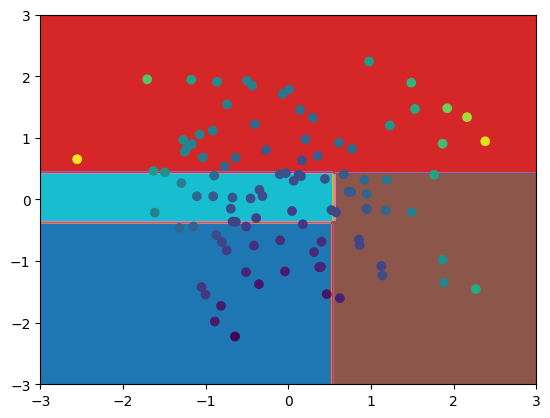

In [38]:
from sklearn.inspection import DecisionBoundaryDisplay


def l2_loss(preds, train_data):
    """
    Custom L2 loss (MSE) objective function.

    Args:
    preds (numpy.ndarray): The predicted values.
    train_data (lightgbm.Dataset): The training dataset.

    Returns:
    Tuple[numpy.ndarray, numpy.ndarray]: The gradients and hessians.
    """
    labels = train_data.get_label()
    residuals = preds - labels
    gradients = 2 * residuals
    hessians = 2 * np.ones_like(preds)
    return gradients, hessians


def l2_eval(preds, train_data):
    """
    Custom L2 eval (MSE) function.

    Args:
    preds (numpy.ndarray): The predicted values.
    train_data (lightgbm.Dataset): The training dataset.

    Returns:
    Tuple[str, float, bool]: Evaluation name, value, and whether lower is better.
    """
    labels = train_data.get_label()
    mse = np.mean((preds - labels) ** 2)
    return (
        "mse",
        mse,
        False,
    )  # 'False' indicates that lower is not better for this metric


ds = lgb.Dataset(x, y)
ds = lgb.Dataset(x, y)
params = {"learning_rate": 1.0, "n_estimators": 1, "verbose": -1, "objective": l2_loss}

model = lgb.train(params, ds, feval=l2_eval)

X, Y = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))
Z = model.predict(np.array([X.ravel(), Y.ravel()]).T, pred_leaf=True).reshape(X.shape)

display = DecisionBoundaryDisplay(xx0=X, xx1=Y, response=Z)
display.plot(cmap="tab10")
display.ax_.scatter(x[:, 0], x[:, 1], c=y, cmap="viridis")

[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements


/home/matt/code/school/joplen/code/joplen-tests/my_env/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning:

Found `n_estimators` in params. Will use it instead of argument



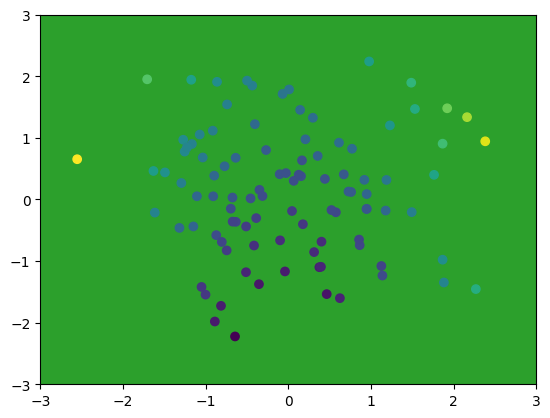

In [40]:
def l2_loss(preds, train_data):
    """
    Custom L2 loss (MSE) objective function.

    Args:
    preds (numpy.ndarray): The predicted values.
    train_data (lightgbm.Dataset): The training dataset.

    Returns:
    Tuple[numpy.ndarray, numpy.ndarray]: The gradients and hessians.
    """
    labels = train_data.get_label()
    residuals = preds - labels
    gradients = 2 * residuals
    hessians = 2 * np.ones_like(preds)
    return -gradients, -hessians


def l2_eval(preds, train_data):
    """
    Custom L2 eval (MSE) function.

    Args:
    preds (numpy.ndarray): The predicted values.
    train_data (lightgbm.Dataset): The training dataset.

    Returns:
    Tuple[str, float, bool]: Evaluation name, value, and whether lower is better.
    """
    labels = train_data.get_label()
    mse = np.mean((preds - labels) ** 2)
    return (
        "-mse",
        -mse,
        True,
    )  # 'False' indicates that lower is not better for this metric


ds = lgb.Dataset(x, y)
ds = lgb.Dataset(x, y)
params = {"learning_rate": 1.0, "n_estimators": 1, "verbose": -1, "objective": l2_loss}

model = lgb.train(params, ds, feval=l2_eval)

X, Y = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))
Z = model.predict(np.array([X.ravel(), Y.ravel()]).T, pred_leaf=True).reshape(X.shape)

display = DecisionBoundaryDisplay(xx0=X, xx1=Y, response=Z)
display.plot(cmap="tab10")
display.ax_.scatter(x[:, 0], x[:, 1], c=y, cmap="viridis")

In [17]:
Z = model.predict(np.array([X.ravel(), Y.ravel()]).T).reshape(X.shape)

fig = go.Figure()

# Add the first scatter plot
fig.add_trace(
    go.Scatter3d(x=x[:, 0], y=x[:, 1], z=y, mode="markers", marker=dict(color="red"))
)

fig.add_trace(go.Surface(x=X, y=Y, z=Z, opacity=0.5))

# Update the layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

# Show the figure
fig.show()

In [170]:
from typing import Callable, Tuple, Optional
import numpy as np
import networkx as nx


class RegressionTreeNode:
    def __init__(self):
        self.threshold = None
        self.feature_index = None
        self.left = None
        self.right = None
        self.output = None
        self.index = None  # New attribute for node index


class RegressionTree:
    def __init__(
        self,
        impurity_function: Optional[Callable] = None,
        min_samples_leaf: int = 2,
        max_depth=10,
    ):
        self.root = RegressionTreeNode()
        self.impurity_function = (
            impurity_function if impurity_function else self.default_impurity_function
        )
        self.min_samples_leaf = min_samples_leaf
        self.max_depth = max_depth

    def default_impurity_function(self, y: np.ndarray) -> float:
        """Default impurity function (Variance)"""
        return np.var(y)

    def best_split(
        self, X: np.ndarray, y: np.ndarray
    ) -> Tuple[Optional[float], Optional[int]]:
        """Find the best split for a node"""
        min_impurity = np.inf
        best_threshold = None
        best_feature = None

        for feature_index in range(X.shape[1]):
            thresholds = np.unique(X[:, feature_index])
            for threshold in thresholds:
                left_mask = X[:, feature_index] <= threshold
                right_mask = X[:, feature_index] > threshold

                # Skip the split if it does not meet the minimum samples requirement
                if (
                    len(y[left_mask]) < self.min_samples_leaf
                    or len(y[right_mask]) < self.min_samples_leaf
                ):
                    continue

                left_impurity = self.impurity_function(y[left_mask])
                right_impurity = self.impurity_function(y[right_mask])
                impurity = left_impurity * len(y[left_mask]) + right_impurity * len(
                    y[right_mask]
                )
                if impurity < min_impurity:
                    min_impurity = impurity
                    best_threshold = threshold
                    best_feature = feature_index

        return best_threshold, best_feature

    def fit(
        self,
        X: np.ndarray,
        y: np.ndarray,
        node: Optional[RegressionTreeNode] = None,
        depth: int = 0,
        index: int = 0,
    ):
        """Recursive function to build the tree"""
        if node is None:
            node = self.root

        if depth is None:
            depth = 0

        node.index = index  # Assign index to the node

        if depth == self.max_depth or len(y) == 0:
            node.output = np.mean(y)
            return

        threshold, feature = self.best_split(X, y)
        if threshold is None:
            node.output = np.mean(y)
            return

        node.threshold = threshold
        node.feature_index = feature
        left_mask = X[:, feature] <= threshold
        right_mask = X[:, feature] > threshold

        # Handle cases where a split results in an empty subset
        if len(y[left_mask]) == 0 or len(y[right_mask]) == 0:
            node.output = np.mean(y)
            return

        # Assigning indices and recursively fitting left and right child nodes
        node.left = RegressionTreeNode()
        self.fit(X[left_mask], y[left_mask], node.left, depth + 1, index)

        node.right = RegressionTreeNode()
        self.fit(
            X[right_mask],
            y[right_mask],
            node.right,
            depth + 1,
            index + 2 ** (self.max_depth - (depth + 1)),
        )

    def predict(
        self, X: np.ndarray, node: Optional[RegressionTreeNode] = None
    ) -> np.ndarray:
        """Recursive function to make predictions"""
        if node is None:
            node = self.root

        if node.output is not None:
            return np.full(X.shape[0], node.output)

        mask = X[:, node.feature_index] <= node.threshold
        predictions = np.empty(X.shape[0])
        predictions[mask] = self.predict(X[mask], node.left)
        predictions[~mask] = self.predict(X[~mask], node.right)
        return predictions

    def predict_index(
        self, X: np.ndarray, node: Optional[RegressionTreeNode] = None
    ) -> np.ndarray:
        """Recursive function to predict the index of the node where each data point ends"""
        if node is None:
            node = self.root

        if node.output is not None:  # Leaf node
            return np.full(X.shape[0], node.index)

        mask = X[:, node.feature_index] <= node.threshold
        predictions = np.empty(X.shape[0], dtype=int)
        predictions[mask] = self.predict_index(X[mask], node.left)
        predictions[~mask] = self.predict_index(X[~mask], node.right)
        return predictions

In [171]:
np.random.seed(0)

n_points = 1000
x = np.random.randn(n_points, 2)
y = x[:, 0] ** 2 + x[:, 1] + np.random.randn(n_points) * 0.1
# y = np.sin(x[:, 0]) + np.cos(x[:, 1]) + np.random.randn(n_points) * 0.1

# Initialize and train the regression tree
tree = RegressionTree(
    impurity_function=lambda x: -np.var(x) / x.shape[0],
    min_samples_leaf=100,
    max_depth=2,
)
tree.fit(x, y)

index = tree.predict_index(x)

In [174]:
# Predict and evaluate
predictions = tree.predict(x)

# Create a figure
fig = go.Figure()

# Add the first scatter plot
fig.add_trace(
    go.Scatter3d(x=x[:, 0], y=x[:, 1], z=y, mode="markers", marker=dict(color="red"))
)

# Add the predictions
fig.add_trace(
    go.Scatter3d(
        x=x[:, 0],
        y=x[:, 1],
        z=predictions,
        mode="markers",
        marker=dict(color="blue"),
    )
)

# Update the layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

# Show the figure
fig.show()

In [215]:
class VarMaxForest:
    def __init__(
        self,
        n_estimators: int = 100,
        max_depth: int = 3,
        min_samples_leaf: int = 1,
        n_features: int | None = None,
        bootstrap_fraction: float = 1.0,
        random_state=None,
    ):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.n_features = n_features
        self.bootstrap_fraction = bootstrap_fraction
        self.random_state = (
            random_state
            if isinstance(random_state, np.random.RandomState)
            else np.random.RandomState(random_state)
        )

        self.trees = [
            RegressionTree(
                max_depth=max_depth,
                min_samples_leaf=min_samples_leaf,
                impurity_function=lambda x: -np.var(x) / x.shape[0],
            )
            for _ in range(n_estimators)
        ]

    def fit(self, X, y):
        if self.n_features is None:
            self.n_features = int(np.ceil(np.sqrt(X.shape[1])))

        feat_masks = []

        for tree in self.trees:
            feat_mask = self.random_state.choice(
                X.shape[1],
                size=self.n_features,
                replace=False,
            )
            sample_mask = self.random_state.choice(
                X.shape[0],
                size=int(self.bootstrap_fraction * X.shape[0]),
                replace=True,
            )
            # print(X[sample_mask][feat_mask].shape, y[sample_mask].shape)
            tree.fit(X[sample_mask][:, feat_mask], y[sample_mask])
            feat_masks.append(feat_mask)

        self.feat_masks = np.array(feat_masks)

    def predict(self, X):
        predictions = np.zeros(X.shape[0])

        for tree, mask in zip(self.trees, self.feat_masks):
            predictions += tree.predict(X[mask])
        return predictions / len(self.trees)

    def predict_index(self, X):
        predictions = np.zeros((len(self.trees), X.shape[0]))

        for i, (tree, mask) in enumerate(zip(self.trees, self.feat_masks)):
            predictions[i, :] = tree.predict_index(X[:, mask])

        return predictions

In [216]:
model = VarMaxForest(n_estimators=2, max_depth=2, min_samples_leaf=100)
model.fit(x, y)

model0 = model.trees[0]
model1 = model.trees[1]

# show each of their predictions
predictions0 = model0.predict(x)
predictions1 = model1.predict(x)

# Create a figure
fig = go.Figure()

# Add the first scatter plot
fig.add_trace(
    go.Scatter3d(x=x[:, 0], y=x[:, 1], z=y, mode="markers", marker=dict(color="red"))
)

# Add the predictions
fig.add_trace(
    go.Scatter3d(
        x=x[:, 0],
        y=x[:, 1],
        z=predictions0,
        mode="markers",
        marker=dict(color="blue"),
    )
)

fig.add_trace(
    go.Scatter3d(
        x=x[:, 0],
        y=x[:, 1],
        z=predictions1,
        mode="markers",
        marker=dict(color="green"),
    )
)

# Update the layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

# Show the figure
fig.show()

index = model.predict_index(x)

index

array([[2., 2., 2., ..., 1., 2., 0.],
       [2., 1., 2., ..., 1., 2., 0.]])

In [217]:
from JOPLEn.partitioner import TreePartition
from JOPLEn.enums import LossType
from typing import Any


class VarMaxForestPartitioner(TreePartition):
    def _get_leaves(self, x: np.ndarray) -> np.ndarray:
        return self.model.predict_index(x).T

    def _fit_model(self, x: np.ndarray, y: np.ndarray):
        match self.loss_type:
            case LossType.regression:
                model_class = VarMaxForest
            case LossType.binary_classification | LossType.multinomial_classification:
                raise NotImplementedError("Classification not implemented")
            case _:
                raise ValueError("Loss type not supported")

        assert (np.log2(self.n_cells) % 1) == 0, "n_cells must be a power of 2"

        self.model = model_class(
            n_estimators=self.n_partitions,
            max_depth=int(np.log2(self.n_cells)),
            random_state=self.state,
        )

        self.model.fit(x, y.flatten())

    def _prefit_model(self, model: Any):
        self.model = model

In [218]:
from JOPLEn.partitioner import GBPartition

part = GBPartition(
    x,
    y,
    n_cells=4,
    n_partitions=2,
    loss_type=LossType.regression,
    random_state=0,
)

print(part._get_leaves(x).shape)

part = VarMaxForestPartitioner(
    x,
    y,
    n_cells=4,
    n_partitions=2,
    loss_type=LossType.regression,
    random_state=0,
)

print(part._get_leaves(x).shape)

(1000, 2)
(1000, 2)


In [239]:
from JOPLEn.singletask import JOPLEn

model = JOPLEn(
    partitioner=VarMaxForestPartitioner,
    n_cells=4,
    random_state=0,
    n_partitions=100,
)

history = model.fit(x, y, max_iters=1000, print_epochs=50)

predictions = model.predict(x)

[11:16:02]: Epoch     50 | TrL: 1.475358 | FNorm: 0.036178 | PNorm: 3.071033 | WNz:    3 | Obj: 0.787375
[11:16:02]: Epoch    100 | TrL: 1.121521 | FNorm: 0.373966 | PNorm: 10.122884 | WNz:    3 | Obj: 0.458604
[11:16:02]: Epoch    150 | TrL: 0.833444 | FNorm: 1.096412 | PNorm: 17.697929 | WNz:    3 | Obj: 0.262286
[11:16:02]: Epoch    200 | TrL: 0.596954 | FNorm: 1.972641 | PNorm: 23.613131 | WNz:    3 | Obj: 0.148803
[11:16:02]: Epoch    250 | TrL: 0.442336 | FNorm: 2.876529 | PNorm: 27.808567 | WNz:    3 | Obj: 0.099785
[11:16:02]: Epoch    300 | TrL: 0.395475 | FNorm: 3.661423 | PNorm: 30.892517 | WNz:    3 | Obj: 0.093470
[11:16:02]: Epoch    350 | TrL: 0.369084 | FNorm: 4.136963 | PNorm: 32.848206 | WNz:    3 | Obj: 0.090950
[11:16:02]: Epoch    400 | TrL: 0.340864 | FNorm: 4.242491 | PNorm: 33.414738 | WNz:    3 | Obj: 0.084767
[11:16:02]: Epoch    450 | TrL: 0.316534 | FNorm: 4.102084 | PNorm: 32.943787 | WNz:    3 | Obj: 0.077575
[11:16:02]: Epoch    500 | TrL: 0.310350 | FNor

In [240]:
# Create a figure
fig = go.Figure()

# Add the first scatter plot
fig.add_trace(
    go.Scatter3d(x=x[:, 0], y=x[:, 1], z=y, mode="markers", marker=dict(color="red"))
)

# Add the predictions
fig.add_trace(
    go.Scatter3d(
        x=x[:, 0],
        y=x[:, 1],
        z=predictions.flatten(),
        mode="markers",
        marker=dict(color="blue"),
    )
)

# Update the layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

# Show the figure
fig.show()